# CartPole-v0

Ref: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
# !sudo cp /opt/conda/lib/libpython3.9.so.1.0 /usr/lib

In [2]:
!python --version

Python 3.8.10


In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.7.0'

In [6]:
import tf_agents
tf_agents.__version__

'0.11.0'

In [42]:
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

import reverb

import tensorflow as tf
import pyvirtualdisplay


import PIL
# import pyvirtualdisplay
import numpy as np

In [13]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [14]:
learning_rate=1e-3
num_eval_episodes=100
replay_buffer_max_length=100

## Environment

In [15]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [16]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.0250906 ,  0.04033611, -0.02563053,  0.01598087], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [17]:
frame = env.render(mode='rgb_array')

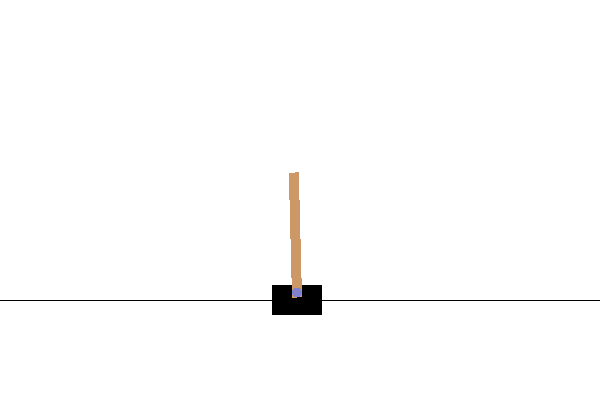

In [18]:
PIL.Image.fromarray(frame)

In [19]:
print('Time Step Spec:')
print(env.time_step_spec())

Time Step Spec:
TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})


In [20]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [21]:
time_step = env.reset()
time_step


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02350678,  0.03814077, -0.02836872, -0.02713963], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [22]:
action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
next_time_step

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0242696 ,  0.23365782, -0.02891151, -0.3286365 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})

In [23]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [24]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [25]:
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

In [26]:
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

In [27]:
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

In [28]:
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [30]:
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policy

In [31]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Random Policy Example

In [32]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [33]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [34]:
time_step = example_environment.reset()

In [44]:
# for _ in range(100):
#     action = random_policy.action(time_step)
    
#     time_step = example_environment.step(action)
    
#     print(time_step.is_last(), time_step.reward, action)

## Metrics and Evaluation

In [36]:
def compute_avg_return(environment, policy, num_episodes=10):
    
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return =0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [37]:
compute_avg_return(example_environment, random_policy, num_eval_episodes)

23.06

## Replay Buffer

In [43]:
table_name = 'uniform_table'

replay_buffer_signature = tensor_spec.from_spec(
    agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)